## Librerias

In [1]:
from google.cloud import bigquery
from time import time
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Parametros

In [2]:
# Datos de las tablas a traer
proyecto = 'co-keralty-costomedico'
dataset = 'Diabetes_avicena_new'

# Nombres de tablas disponibles en el dataset
tables = ['diabetes', 'examenes_por_usuarios','antecedentes_x_usuario','perimetros_x_usuarios','actividadFisica_x_usuarios','diabetes_copy']

client_bq = bigquery.Client(project= proyecto)


tipo_identificacion = {
    'Cédula de ciudadanía' : 0,
    'Tarjeta de identidad' : 1,
    'Cédula de extranjería' : 2,
    'Permiso por Protección Temporal' : 3,
    'Pasaporte' : 4,
    'Permiso Especial de Permanencia' : 5,
    'Salvo Conducto de Permanencia' : 6,
}

nivel_academico = {
    'Básica secundaria' : 0,
    'Básica primaria' : 1,
    'Normalista' : 2,
    'Ninguno' : 3,
    'Profesional' : 4,
    'Técnica profesional' : 5,
    'Preescolar' : 6,
    'Bachillerato técnico' : 7,
    'Media académica o clásica' : 8,
    'Tecnológica' : 9,
    'Maestría' : 10,
    'Especialización' : 11,
    'Doctorado' : 12,
    'None' : 13,
}

raza_paciente = {
    'Otros' : 0,
    'Mestizo' : 1,
    'Raizales' : 2,
    'Afrocolombiano' : 3,
    'Indígena' : 4,
    'Palenquero' : 5,
    'Rom/Gitano' : 6,
    'None' : 7,
}

ejercicio = {
    '20 minutos\n' : 0,
    '40 minutos\n' : 1,
    'Nunca\n' : 2,
    '60 minutos\n' : 3,
}


## Funciones

In [3]:
def bring_data_from_bq(table, client_bq, query = '', save = False, read_local = False):

    print(f'Leyendo datos de la tabla: {table}')

    if query == '':
        query = f"""SELECT * FROM {proyecto}.{dataset}.{table} WHERE edad >= 18"""

    if read_local:
        data = pd.read_parquet(f'{table}.parquet')
    else:
        data = client_bq.query(query).result().to_dataframe()

        if save:
            data.to_parquet(f'{table}.parquet')
            print(f'Informacion guardada en el archivo: {table}.parquet')

    return data

def prepare_data(data):
    data_new = data.copy()

    campos = [['tipo_identificacion_paciente',tipo_identificacion],['nivel_academico_paciente',nivel_academico],['raza_paciente',raza_paciente],['hace_ejercicio',ejercicio]]

    for tupla in campos:
        data_new[tupla[0]] = data_new[tupla[0]].replace(tupla[1])

    data_new = data_new.drop(columns=['numero_identificacion_paciente','albuminuria']).astype(float)

    return data_new.drop_duplicates()

## Carga de datos

In [9]:
data_original = bring_data_from_bq(table = tables[0], client_bq = client_bq, save = True, read_local = False)
data = prepare_data(data_original)

data.head(5)

Leyendo datos de la tabla: diabetes


Forbidden: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/co-keralty-costomedico/jobs?prettyPrint=false: Caller does not have required permission to use project co-keralty-costomedico. Grant the caller the roles/serviceusage.serviceUsageConsumer role, or a custom role with the serviceusage.services.use permission, by visiting https://console.developers.google.com/iam-admin/iam/project?project=co-keralty-costomedico and then retry. Propagation of the new permission may take a few minutes.

Location: None
Job ID: 803cd771-a6ba-4d9e-b3d9-8df9eb41a190
 [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Google developer console IAM admin', 'url': 'https://console.developers.google.com/iam-admin/iam/project?project=co-keralty-costomedico'}]}, {'@type': 'type.googleapis.com/google.rpc.ErrorInfo', 'reason': 'USER_PROJECT_DENIED', 'domain': 'googleapis.com', 'metadata': {'service': 'bigquery.googleapis.com', 'consumer': 'projects/co-keralty-costomedico'}}]

## ¿Cuánta información se encuentra?

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292536 entries, 0 to 292535
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   tipo_identificacion_paciente  292536 non-null  float64
 1   edad                          292536 non-null  float64
 2   genero                        292536 non-null  float64
 3   codigo_ciudad_sucursal        292536 non-null  float64
 4   nivel_academico_paciente      292527 non-null  float64
 5   raza_paciente                 292527 non-null  float64
 6   peso                          292536 non-null  float64
 7   talla                         292536 non-null  float64
 8   imc                           292536 non-null  float64
 9   HDL                           292536 non-null  float64
 10  LDL                           292536 non-null  float64
 11  trigliceridos                 292536 non-null  float64
 12  med_hipertension              292536 non-nul

In [6]:
data.describe()

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
count,292536.000000,292536.000000,292536.000000,292536.000000,292527.000000,292527.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000
mean,0.019088,59.097732,0.383037,28903.630087,2.625488,0.175184,73.758353,1.611391,28.331444,48.006205,109.090474,154.455188,0.661638,0.008502,0.733879,0.004266,93.066485,1.395093,0.301529
std,0.216244,15.500512,0.486128,21838.645651,2.746173,0.581321,15.958150,0.094033,5.618801,27.564151,279.267558,478.889615,0.473153,0.091811,0.441929,0.065176,12.994989,0.992946,0.458923
min,0.000000,18.000000,0.000000,5001.000000,0.000000,0.000000,2.870000,0.300000,4.140625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000
25%,0.000000,48.000000,0.000000,11001.000000,0.000000,0.000000,63.000000,1.550000,24.807492,39.200000,79.800000,97.400000,0.000000,0.000000,0.000000,0.000000,85.000000,0.000000,0.000000
50%,0.000000,61.000000,0.000000,19001.000000,3.000000,0.000000,72.000000,1.600000,27.717685,46.000000,105.500000,133.000000,1.000000,0.000000,1.000000,0.000000,92.000000,2.000000,0.000000
75%,0.000000,70.000000,1.000000,50001.000000,4.000000,0.000000,82.900000,1.680000,31.170468,54.000000,132.800000,183.000000,1.000000,0.000000,1.000000,0.000000,100.000000,2.000000,1.000000
max,6.000000,107.000000,1.000000,88001.000000,12.000000,6.000000,300.000000,2.060000,777.777778,6708.000000,94167.000000,253000.000000,1.000000,1.000000,1.000000,1.000000,374.000000,3.000000,1.000000


## ¿cuantos datos son nulos?

In [7]:
null_counts = data.isnull().sum()
print("\nDatos nulos por variable:")
print(null_counts)


Datos nulos por variable:
tipo_identificacion_paciente    0
edad                            0
genero                          0
codigo_ciudad_sucursal          0
nivel_academico_paciente        9
raza_paciente                   9
peso                            0
talla                           0
imc                             0
HDL                             0
LDL                             0
trigliceridos                   0
med_hipertension                0
familiar_dm                     0
ant_cardiovascular              0
dm_gestacional                  0
PERIMETRO_ABDOMINAL             0
hace_ejercicio                  0
diabetes                        0
dtype: int64


## ¿Calcular el número de personas con diabetes y sin diabetes?

In [8]:
if 'diabetes' in data.columns:
    personas_con_diabetes = data[data['diabetes'] == True].shape[0]
    personas_sin_diabetes = data[data['diabetes'] == False].shape[0]
    print(f"Personas con diabetes: {personas_con_diabetes}")
    print(f"Personas sin diabetes: {personas_sin_diabetes}")
else:
    raise ValueError("La columna 'diabetes' no existe en el DataFrame")

Personas con diabetes: 88208
Personas sin diabetes: 204328


## Relacion entre las variables

### Distribuciones

Los estadisticos descriptivos para la columna tipo_identificacion_paciente son
Media: 0.019088248967648425
Mediana: 0.0
Moda: 0    0.0
Name: tipo_identificacion_paciente, dtype: float64


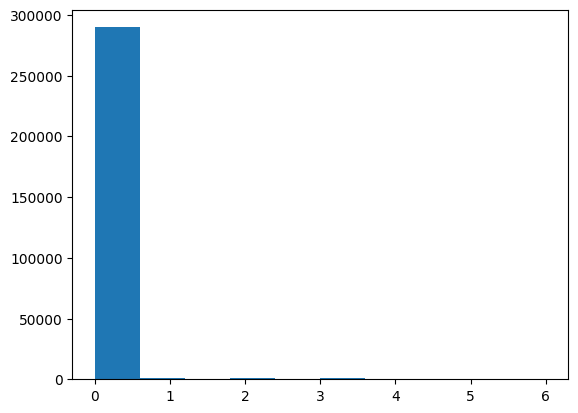

--------------------------------------------------------------
Los estadisticos descriptivos para la columna edad son
Media: 59.09773156124374
Mediana: 61.0
Moda: 0    64.0
Name: edad, dtype: float64


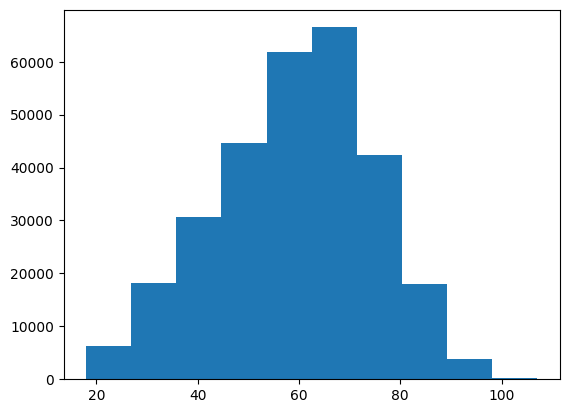

--------------------------------------------------------------
Los estadisticos descriptivos para la columna genero son
Media: 0.38303661771542646
Mediana: 0.0
Moda: 0    0.0
Name: genero, dtype: float64


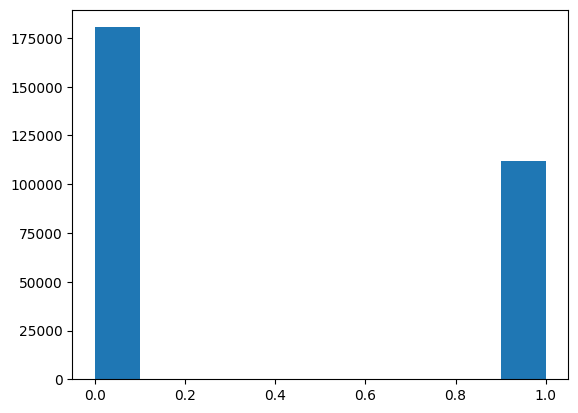

--------------------------------------------------------------
Los estadisticos descriptivos para la columna codigo_ciudad_sucursal son
Media: 28903.63008655345
Mediana: 19001.0
Moda: 0    11001.0
Name: codigo_ciudad_sucursal, dtype: float64


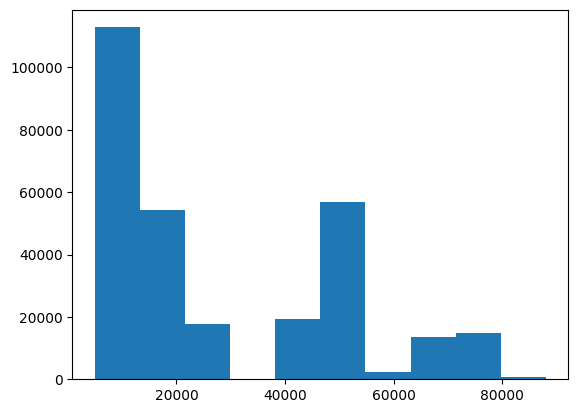

--------------------------------------------------------------
Los estadisticos descriptivos para la columna nivel_academico_paciente son
Media: 2.6254875618318994
Mediana: 3.0
Moda: 0    0.0
Name: nivel_academico_paciente, dtype: float64


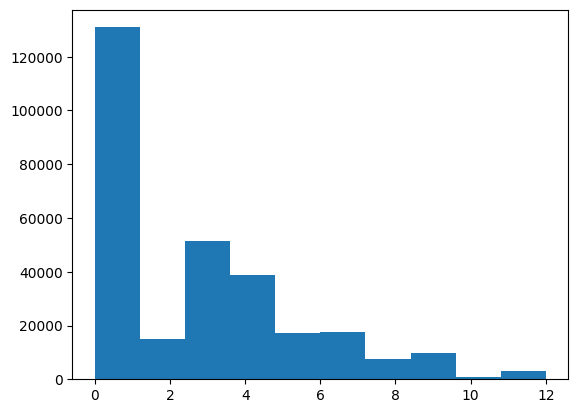

--------------------------------------------------------------
Los estadisticos descriptivos para la columna raza_paciente son
Media: 0.1751838291849983
Mediana: 0.0
Moda: 0    0.0
Name: raza_paciente, dtype: float64


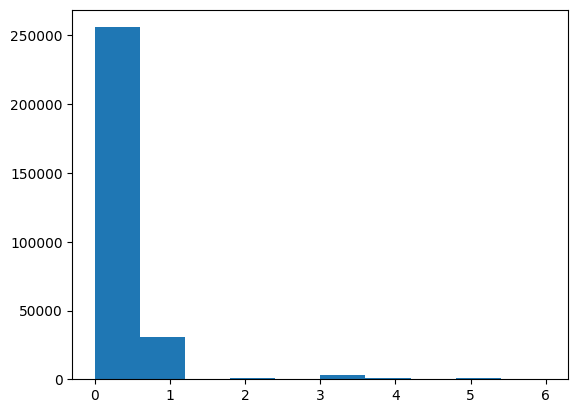

--------------------------------------------------------------
Los estadisticos descriptivos para la columna peso son
Media: 73.75835336505594
Mediana: 72.0
Moda: 0    70.0
Name: peso, dtype: float64


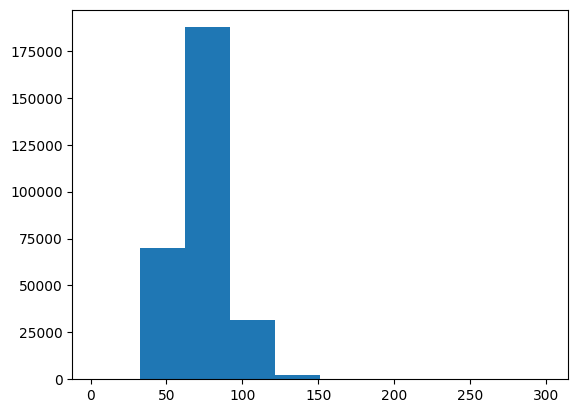

--------------------------------------------------------------
Los estadisticos descriptivos para la columna talla son
Media: 1.6113914663494406
Mediana: 1.6
Moda: 0    1.6
Name: talla, dtype: float64


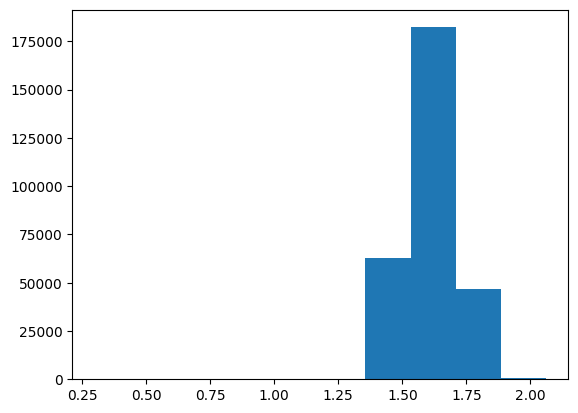

--------------------------------------------------------------
Los estadisticos descriptivos para la columna imc son
Media: 28.3314442169871
Mediana: 27.717685235
Moda: 0    27.34375
Name: imc, dtype: float64


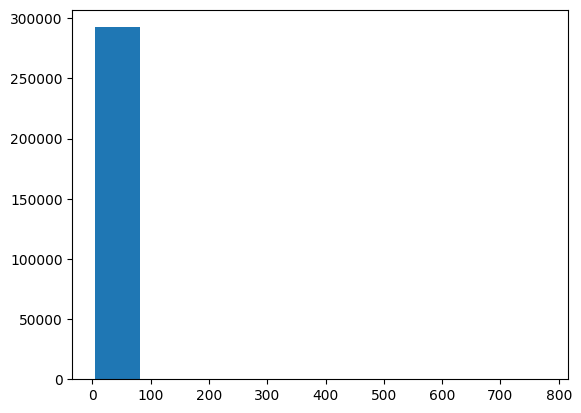

--------------------------------------------------------------
Los estadisticos descriptivos para la columna HDL son
Media: 48.00620532173817
Mediana: 46.0
Moda: 0    45.0
Name: HDL, dtype: float64


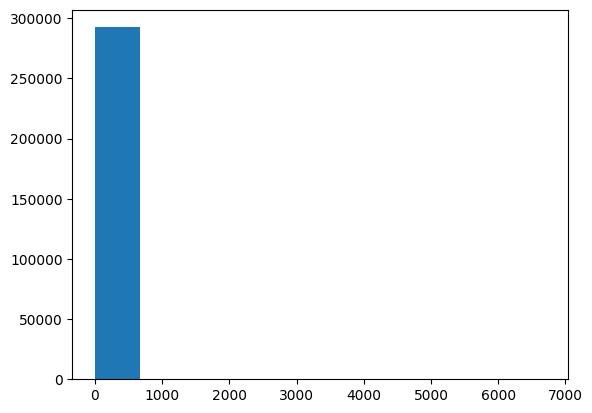

--------------------------------------------------------------
Los estadisticos descriptivos para la columna LDL son
Media: 109.09047402712827
Mediana: 105.5
Moda: 0    100.0
Name: LDL, dtype: float64


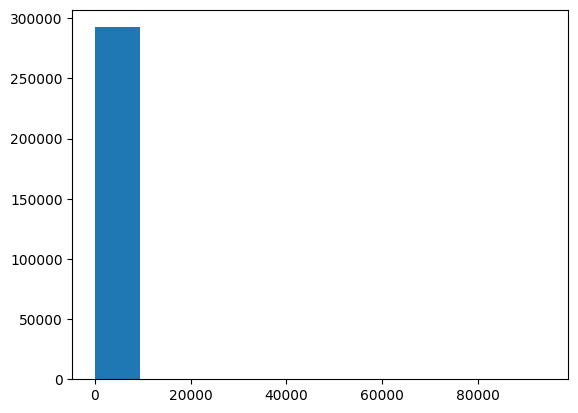

--------------------------------------------------------------
Los estadisticos descriptivos para la columna trigliceridos son
Media: 154.45518760084227
Mediana: 133.0
Moda: 0    110.0
Name: trigliceridos, dtype: float64


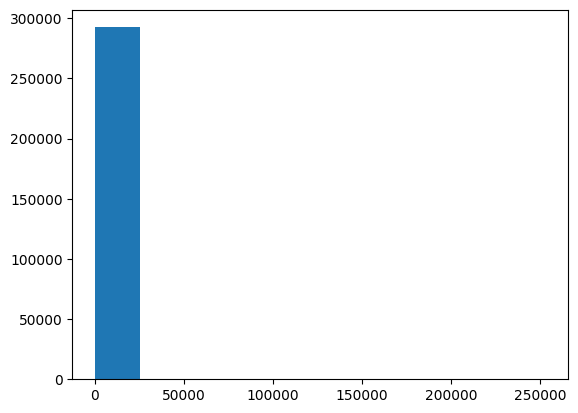

--------------------------------------------------------------
Los estadisticos descriptivos para la columna med_hipertension son
Media: 0.6616382257226461
Mediana: 1.0
Moda: 0    1.0
Name: med_hipertension, dtype: float64


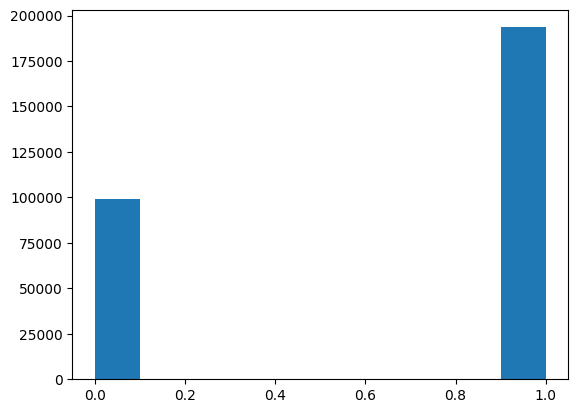

--------------------------------------------------------------
Los estadisticos descriptivos para la columna familiar_dm son
Media: 0.008501517761916481
Mediana: 0.0
Moda: 0    0.0
Name: familiar_dm, dtype: float64


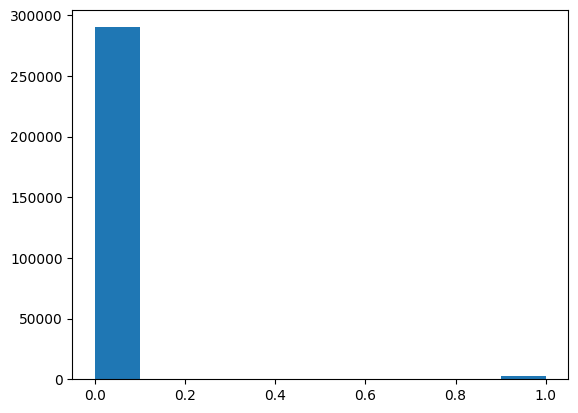

--------------------------------------------------------------
Los estadisticos descriptivos para la columna ant_cardiovascular son
Media: 0.7338789072114201
Mediana: 1.0
Moda: 0    1.0
Name: ant_cardiovascular, dtype: float64


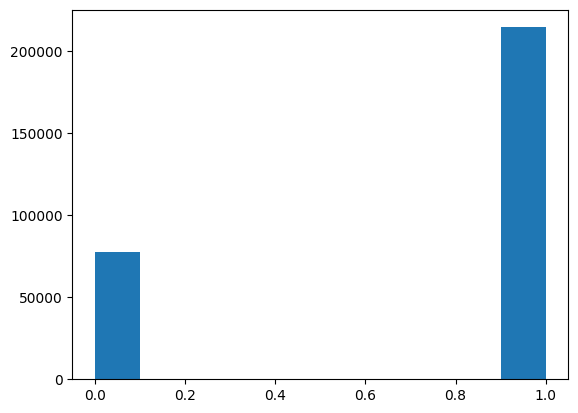

--------------------------------------------------------------
Los estadisticos descriptivos para la columna dm_gestacional son
Media: 0.004266141603084748
Mediana: 0.0
Moda: 0    0.0
Name: dm_gestacional, dtype: float64


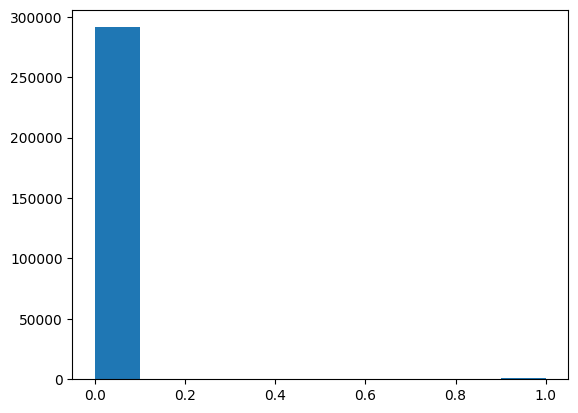

--------------------------------------------------------------
Los estadisticos descriptivos para la columna PERIMETRO_ABDOMINAL son
Media: 93.06648521891323
Mediana: 92.0
Moda: 0    90.0
Name: PERIMETRO_ABDOMINAL, dtype: float64


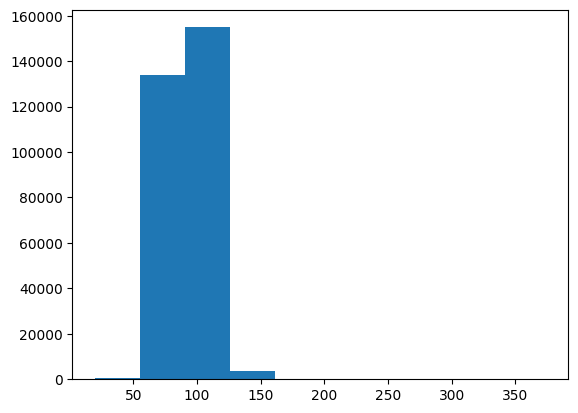

--------------------------------------------------------------
Los estadisticos descriptivos para la columna hace_ejercicio son
Media: 1.3950932534799136
Mediana: 2.0
Moda: 0    2.0
Name: hace_ejercicio, dtype: float64


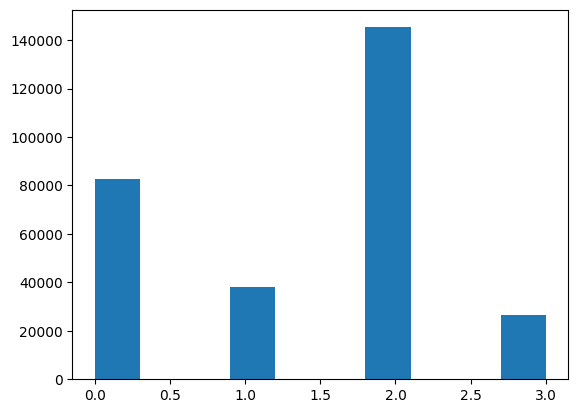

--------------------------------------------------------------
Los estadisticos descriptivos para la columna diabetes son
Media: 0.3015287007411054
Mediana: 0.0
Moda: 0    0.0
Name: diabetes, dtype: float64


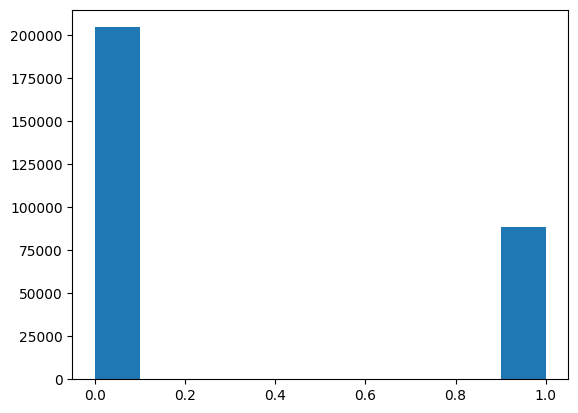

--------------------------------------------------------------


In [10]:
for column in data.columns:
    print(f'Los estadisticos descriptivos para la columna {column} son')
    print(f'Media: {data[column].mean()}')
    print(f'Mediana: {data[column].median()}')
    print(f'Moda: {data[column].mode()}')
    plt.hist(data[column])
    plt.show()
    print('--------------------------------------------------------------')

### Correlaciones

#### Variables Categoricas

In [13]:
variables_categoricas = ['tipo_identificacion_paciente','genero','codigo_ciudad_sucursal','nivel_academico_paciente','raza_paciente','med_hipertension','familiar_dm','ant_cardiovascular','dm_gestacional','hace_ejercicio']

for variable in variables_categoricas:
    print('------------------------------------------------------------------------------------')
    print(f'Resultado de correlacion entre la variable {variable} y diabetes')

    # Tabla de contingencia
    dataset = pd.crosstab(data[variable],data['diabetes'])
    display(dataset)

    # Calculo de Chi-cuadrado
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    print(f'El estadistico Chi-cuadrado es: {X2}')

    # Sumar el Arreglo
    N = np.sum(np.array(dataset)) 
    print(f'La suma de las frecuencias es: {N}')

    # Encontrar el minimo entre la cantidad de filas y columnas
    minimum_dimension = min(dataset.shape)-1
    print(f'La dimension usada es: {minimum_dimension}')

    # Calculo del coeficiente de Cramer
    result = np.sqrt((X2/N) / minimum_dimension) 
    print(f'El coeficiente de Cramer es: {result}')

------------------------------------------------------------------------------------
Resultado de correlacion entre la variable tipo_identificacion_paciente y diabetes


diabetes,0.0,1.0
tipo_identificacion_paciente,,
0.0,202340,87527
1.0,614,99
2.0,734,413
3.0,595,139
4.0,2,0
5.0,42,29
6.0,1,1


El estadistico Chi-cuadrado es: 157.43842870546771
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.023198810318204647
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable genero y diabetes


diabetes,0.0,1.0
genero,,
0.0,129989,50495
1.0,74339,37713


El estadistico Chi-cuadrado es: 1058.6875943200519
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.06015811958166036
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable codigo_ciudad_sucursal y diabetes


diabetes,0.0,1.0
codigo_ciudad_sucursal,,
5001.0,9736,3713
5088.0,6,2
5266.0,47,21
5360.0,3,2
5615.0,1056,82
...,...,...
76834.0,36,4
76892.0,319,95
81001.0,119,53


El estadistico Chi-cuadrado es: 5199.444621638104
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.13331800897505092
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable nivel_academico_paciente y diabetes


diabetes,0.0,1.0
nivel_academico_paciente,,
0.0,72097,32417
1.0,17326,9102
2.0,10070,4894
3.0,35264,16211
4.0,28768,10019
5.0,12887,4470
6.0,684,320
7.0,11947,4691
8.0,5020,2630


El estadistico Chi-cuadrado es: 1148.6261801945375
La suma de las frecuencias es: 292527
La dimension usada es: 1
El coeficiente de Cramer es: 0.06266230652995282
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable raza_paciente y diabetes


diabetes,0.0,1.0
raza_paciente,,
0.0,177068,78843
1.0,23186,7505
2.0,366,201
3.0,2237,1041
4.0,824,333
5.0,418,161
6.0,221,123


El estadistico Chi-cuadrado es: 544.8683616097179
La suma de las frecuencias es: 292527
La dimension usada es: 1
El coeficiente de Cramer es: 0.04315814966807833
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable med_hipertension y diabetes


diabetes,0.0,1.0
med_hipertension,,
0.0,74180,24803
1.0,130148,63405


El estadistico Chi-cuadrado es: 1843.9817154384393
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.07939417601779414
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable familiar_dm y diabetes


diabetes,0.0,1.0
familiar_dm,,
0.0,202427,87622
1.0,1901,586


El estadistico Chi-cuadrado es: 51.72765643771048
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.013297553369254289
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable ant_cardiovascular y diabetes


diabetes,0.0,1.0
ant_cardiovascular,,
0.0,63876,13974
1.0,140452,74234


El estadistico Chi-cuadrado es: 7500.458656405474
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.16012319655179624
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable dm_gestacional y diabetes


diabetes,0.0,1.0
dm_gestacional,,
0.0,204328,86960
1.0,0,1248


El estadistico Chi-cuadrado es: 2903.295355771174
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.09962215919162622
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable hace_ejercicio y diabetes


diabetes,0.0,1.0
hace_ejercicio,,
0.0,56875,25874
1.0,25888,12076
2.0,102898,42420
3.0,18667,7838


El estadistico Chi-cuadrado es: 166.37465549850407
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.02384810774895942


#### Variables Numericas

In [15]:
variables_numericas = [column for column in data.columns if column not in variables_categoricas]
variables_numericas

['edad',
 'peso',
 'talla',
 'imc',
 'HDL',
 'LDL',
 'trigliceridos',
 'PERIMETRO_ABDOMINAL',
 'diabetes']

In [16]:
px.imshow(data[variables_numericas].corr(method = 'pearson'))

In [17]:
px.imshow(data[variables_numericas].corr(method = 'kendall'))

In [18]:
px.imshow(data[variables_numericas].corr(method = 'spearman'))